In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

from glob import glob
from fractions import Fraction
from math import *

import sys
sys.path.append('/home/xavier/Documents/dcml/python_scripts')

from metric import get_distance
from progression import get_progression, plot_comparison
from data_types import ChordType,PitchType
from constants import TRIAD_REDUCTION
from utils import get_chord_pitches

In [2]:
pd.options.display.max_rows = 50

In [3]:
sonata = pd.read_csv('../Data/sonata_comparisons.csv', converters={'number': str})
sonata.set_index('number', inplace = True)

In [4]:
sonata['avg_sps_normalized'] = (sonata['average_sps']-np.mean(sonata['average_sps']))/np.std(sonata['average_sps'])
sonata['avg_vl_normalized'] = (sonata['average_vl']-np.mean(sonata['average_vl']))/np.std(sonata['average_vl'])
sonata['avg_tbt_normalized'] = (sonata['average_tbt']-np.mean(sonata['average_tbt']))/np.std(sonata['average_tbt'])
sonata['avg_bin_normalized'] = (sonata['average_bin']-np.mean(sonata['average_bin']))/np.std(sonata['average_bin'])

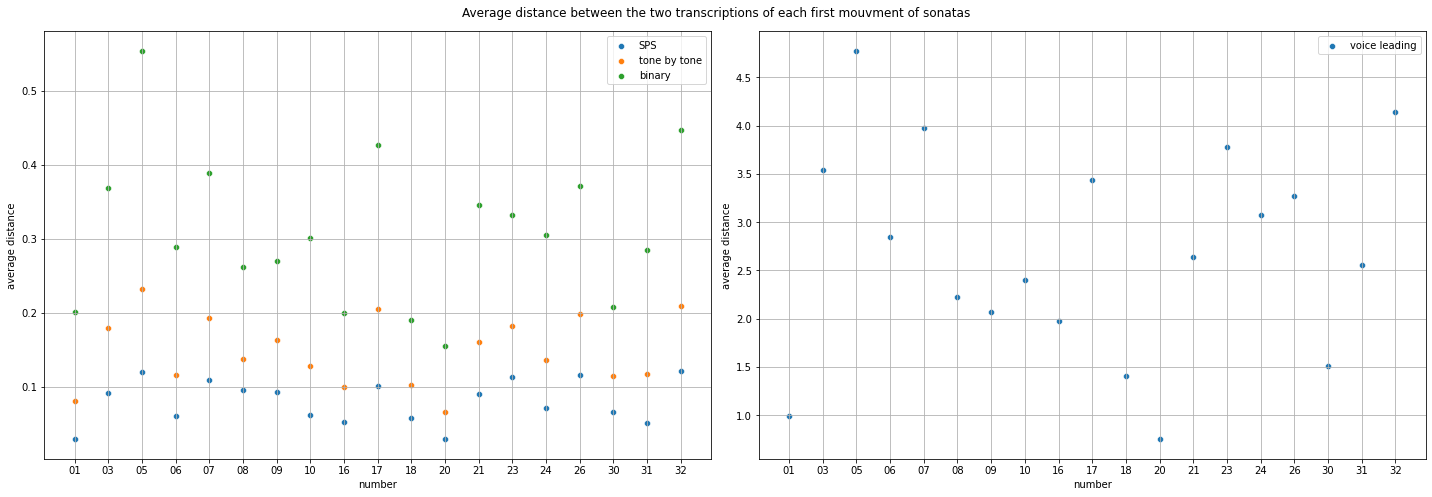

In [5]:
fig, axs = plt.subplots(1,2,figsize=(20,7))

sns.scatterplot(data=sonata, x='number', y='average_sps',ax=axs[0], label='SPS')
sns.scatterplot(data=sonata, x='number', y='average_tbt',ax=axs[0], label='tone by tone')
sns.scatterplot(data=sonata, x='number', y='average_bin',ax=axs[0], label='binary')
sns.scatterplot(data=sonata, x='number', y='average_vl',ax=axs[1], label='voice leading')
axs[0].grid()
axs[0].set(xlabel='number', ylabel='average distance')
axs[1].grid()
axs[1].set(xlabel='number', ylabel='average distance')


fig.suptitle('Average distance between the two transcriptions of each first mouvment of sonatas');
fig.tight_layout()

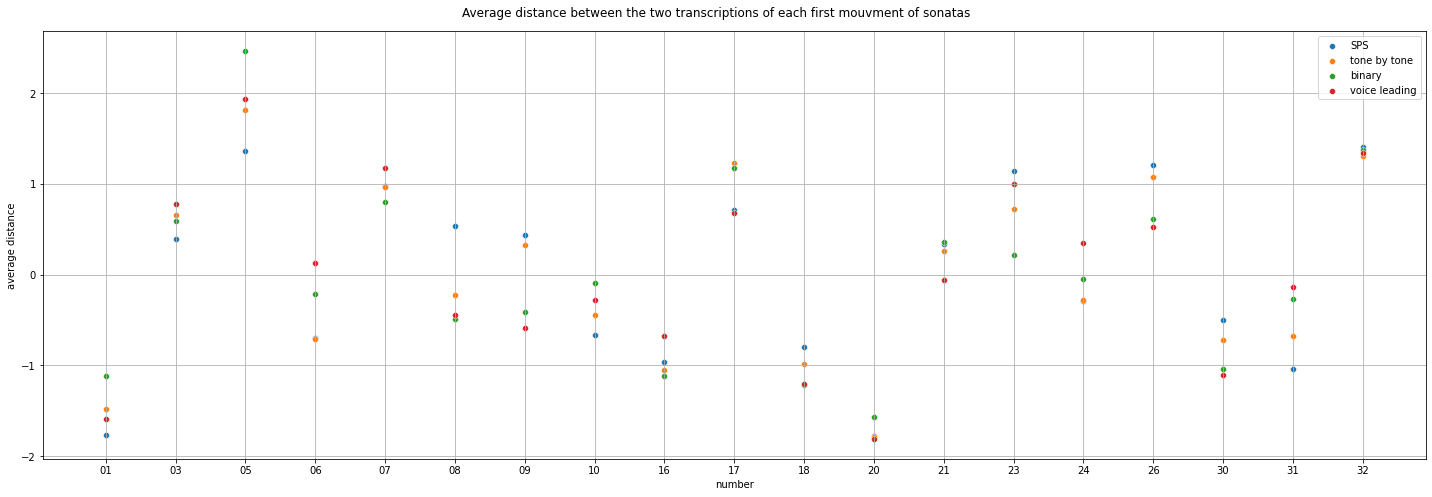

In [6]:
fig, axs = plt.subplots(1,1,figsize=(20,7))

sns.scatterplot(data=sonata, x='number', y='avg_sps_normalized',ax=axs, label='SPS')
sns.scatterplot(data=sonata, x='number', y='avg_tbt_normalized',ax=axs, label='tone by tone')
sns.scatterplot(data=sonata, x='number', y='avg_bin_normalized',ax=axs, label='binary')
sns.scatterplot(data=sonata, x='number', y='avg_vl_normalized',ax=axs, label='voice leading')
axs.grid()
axs.set(xlabel='number', ylabel='average distance')


fig.suptitle('Average distance between the two transcriptions of each first mouvment of sonatas');
fig.tight_layout()

___
___

In [ ]:
nb = 3
nb = str(nb) 
nb = nb if len(nb)>1 else '0'+ nb 
fh_path =  '../Data/Beethoven_sonata_fh/' + nb + '-1.csv'
dcml_path =  '../Data/Beethoven_sonata_dcml/' + nb + '-1.csv'

PITCH_TO_STRING = {0:'C',1:'Db',2:'D',3:'Eb',4:'E',5:'F',
                   6:'Gb',7:'G',8:'Ab',9:'A',10:'Bb',11:'B'}

fh_df = pd.read_csv(fh_path, converters={'duration': Fraction})
fh_df['chord_type'] = fh_df['chord_type'].apply(lambda r : ChordType[r.split(".")[1]])
fh_df['full_chord'] = fh_df.apply(lambda r : PITCH_TO_STRING[r.chord_root_midi] + '_' + str(r.chord_type).split(".")[1]+"_inv"+str(r.chord_inversion), axis=1)    

features = ['interval', 'matched_idx', 'matched_duration', 'chords_sps_dist', 'chords_vl_dist', 'chords_tbt_dist']
for feature in features :
    fh_df[feature] = fh_df[feature].apply(lambda r : ast.literal_eval(r))
    
dcml_df = pd.read_csv(dcml_path, converters={'duration': Fraction})
dcml_df['chord_type'] = dcml_df['chord_type'].apply(lambda r : ChordType[r.split(".")[1]])
dcml_df['full_chord'] = dcml_df.apply(lambda r : PITCH_TO_STRING[r.chord_root_midi] + '_' + str(r.chord_type).split(".")[1]+"_inv"+str(r.chord_inversion), axis=1)    
dcml_df['interval'] = dcml_df['interval'].apply(lambda r : ast.literal_eval(r))

progression = get_progression(dcml_df, fh_df)

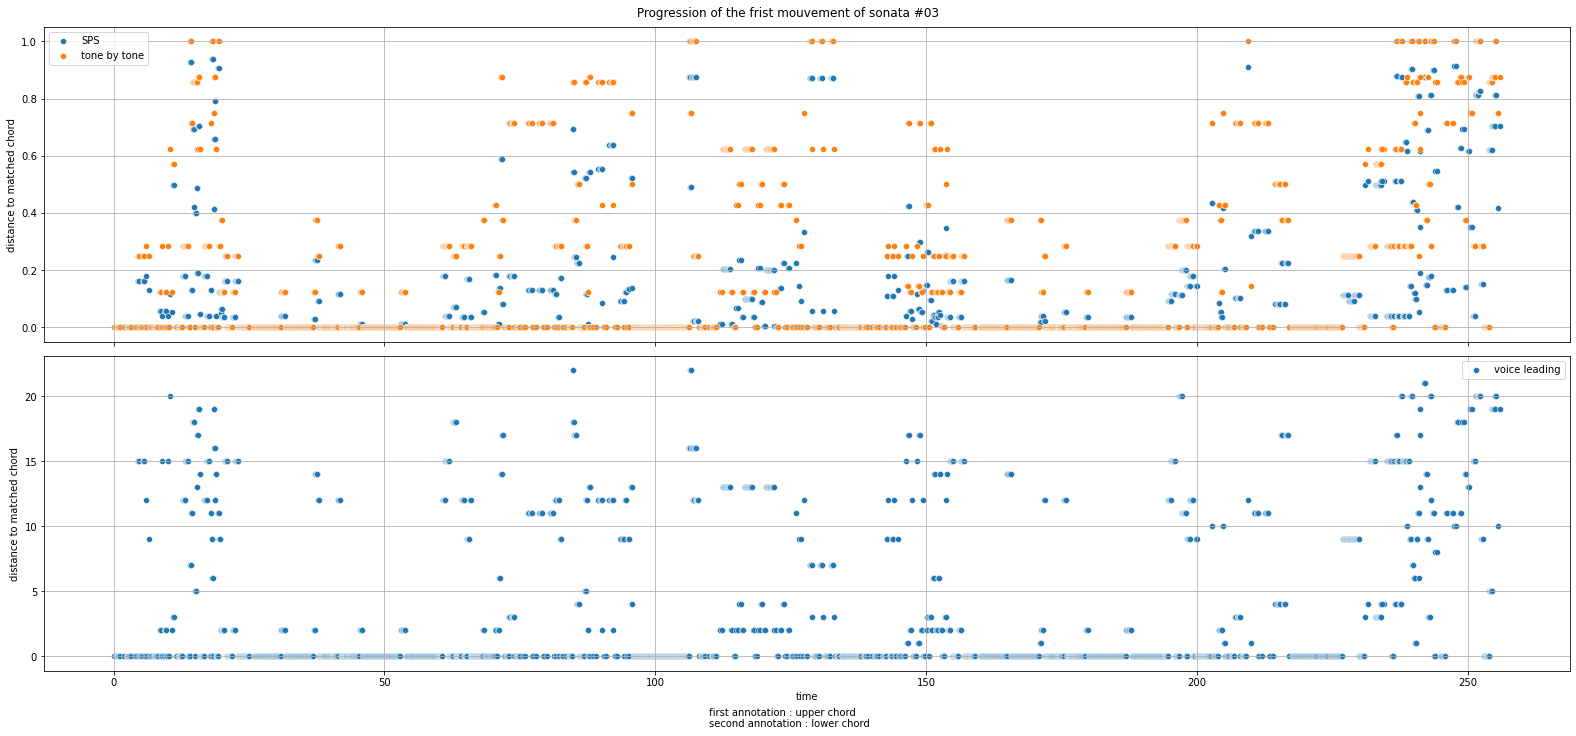

In [5]:
title = 'Progression of the frist mouvement of sonata #'+nb
plot_comparison(progression=progression, title=title)

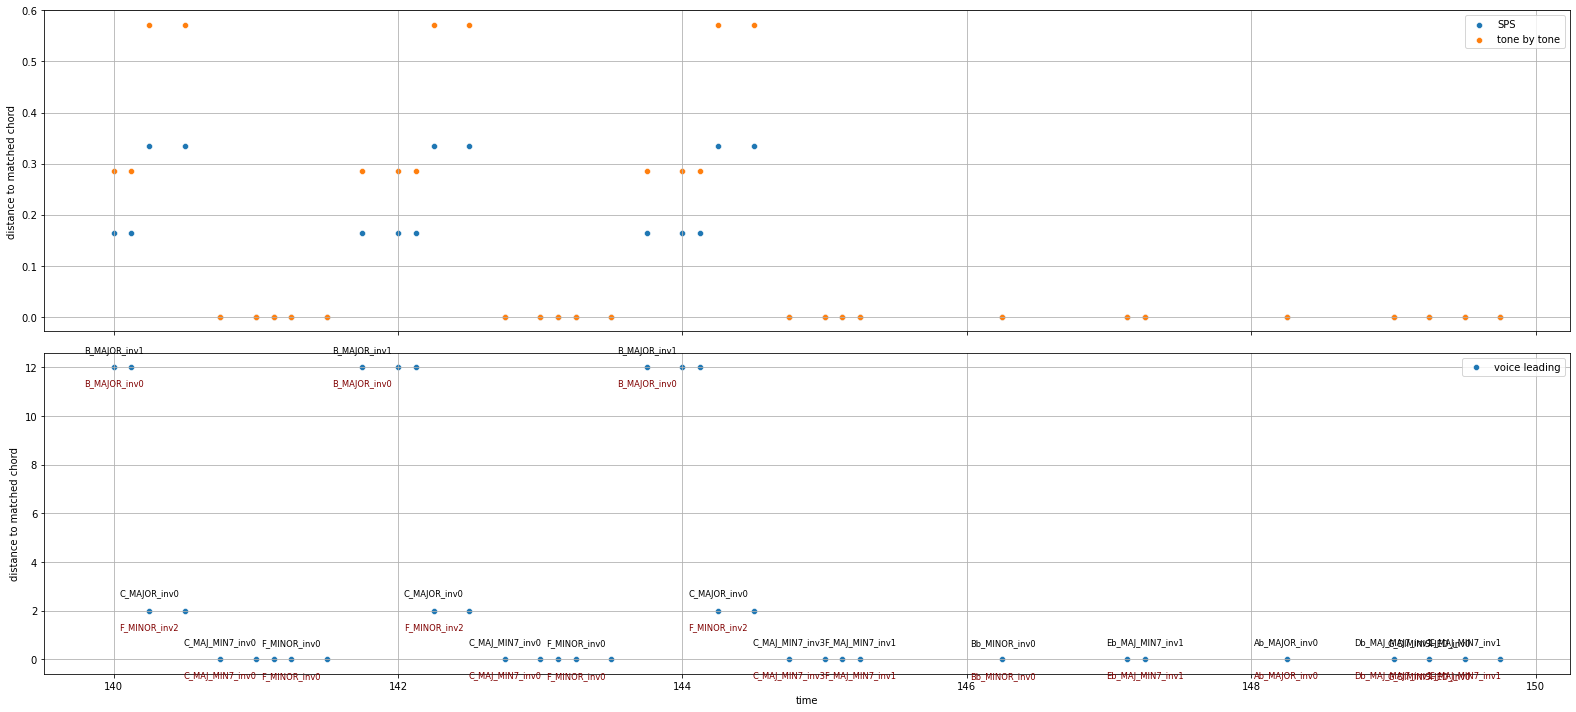

In [31]:
plot_comparison(progression=progression, rge=[140, 150], verbose = True, title=title)

In [ ]:
progression

In [42]:
for idx, r in fh_df.iterrows():
    if r.interval[0]>=241:
        print(r)
        break

chord_root_tpc                                                      1
chord_root_midi                                                     7
chord_type                                         ChordType.MAJ_MIN7
chord_inversion                                                     0
key_tonic_tpc                                                       0
key_tonic_midi                                                      0
key_mode                                                KeyMode.MAJOR
duration                                                            1
interval                                               [241.0, 242.0]
matched_idx          [2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197]
matched_duration    [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...
chords_sps_dist     [0.8750869643567322, 0.8750869643567322, 0.146...
chords_vl_dist           [20.0, 20.0, 14.0, 14.0, 9.0, 9.0, 3.0, 3.0]
chords_tbt_dist      [1.0, 1.0, 0.375, 0.375, 0.875, 0.875, 0.5, 0.5]
full_chord          